# Постановка задачи

  Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
  Предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

# ШАГ 1:

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

Проанализируем датасет звонков

In [128]:
calls = pd.read_csv('/datasets/calls.csv')
display(calls.head())
calls.info()
calls.describe()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


In [129]:
#приведем call_date к типу datetime
calls['call_date'] = pd.to_datetime(calls['call_date'], format="%Y-%m-%d")
#длительность звонков приведем к целым значениям
calls['duration'] = calls['duration'].apply(np.ceil).astype('int16')
#посмотрим на количество дубликатов
print('Количество дубликатов', calls.duplicated().sum())
#посмотрим на звонки, продлившиеся меньше минуты
print('Количество звонков, продлившихся меньше минуты',calls[calls['duration'] == 0]['duration'].count() , ', что составляет {:.1%} от всех звонков'.format(calls[calls['duration'] == 0]['duration'].count() / len(calls)))

Количество дубликатов 0
Количество звонков, продлившихся меньше минуты 39613 , что составляет 19.6% от всех звонков


 Более 20% давольно большой объем данных, если удалить их, получим сильно искаженный анализ. Поэтому предположим, что это звонки длительностью в минуту.

In [130]:
calls['duration'] = calls['duration'].replace(0, 1) 

In [131]:
calls.info()
calls.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null int16
user_id      202607 non-null int64
dtypes: datetime64[ns](1), int16(1), int64(1), object(1)
memory usage: 5.0+ MB


,duration,user_id
count,202607.000000,202607.000000
mean,7.353714,1253.940619
std,5.733230,144.722751
min,1.000000,1000.000000
25%,2.000000,1126.000000
50%,6.000000,1260.000000
75%,11.000000,1379.000000
max,38.000000,1499.000000


Проанализируем датасет интернет

In [132]:
internet = pd.read_csv('/datasets/internet.csv')
display(internet.head())
internet.info()
internet.describe()


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000


In [133]:
#приведем session_date к типу datetime
internet['session_date'] = pd.to_datetime(internet['session_date'], format="%Y-%m-%d")
# id -> int
internet['id'] = internet['id'].astype('int')

In [134]:
internet.info()
internet.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null int64
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 5.7 MB


,Unnamed: 0,id,mb_used,user_id
count,149396.000000,1.493960e+05,149396.000000,149396.000000
mean,74697.500000,8.968475e+05,370.192426,1252.099842
std,43127.054745,5.419758e+05,278.300951,144.050823
min,0.000000,1.000000e+04,0.000000,1000.000000
25%,37348.750000,1.389878e+05,138.187500,1130.000000
50%,74697.500000,1.145212e+06,348.015000,1251.000000
75%,112046.250000,1.321559e+06,559.552500,1380.000000
max,149395.000000,1.499156e+06,1724.830000,1499.000000


Проанализируем датасет сообщений

In [135]:
messages = pd.read_csv('/datasets/messages.csv')
display(messages.head())
messages.describe()
messages.info()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [136]:
#message_date -> datetime
messages['message_date'] = pd.to_datetime(messages['message_date'], format="%Y-%m-%d")
# id -> int
messages['id'] = messages['id'].astype('int')

Проанализируем датасет с тарифами

In [137]:
tariffs = pd.read_csv('/datasets/tariffs.csv')
display(tariffs.head())
tariffs.describe()
tariffs.info()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Здесь все хорошо :)

Проанализируем датасет с пользователями

In [138]:
users = pd.read_csv('/datasets/users.csv')
display(users.head())
users.describe()
users.info()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [139]:
#churn_date -> datetime
users['churn_date'] = pd.to_datetime(users['churn_date'], format="%Y-%m-%d")
#reg_date -> datetime
users['reg_date'] = pd.to_datetime(users['reg_date'], format="%Y-%m-%d")

# ШАГ 2:

In [140]:
#количество сделанных звонков и израсходованных минут разговора по месяцам для каждого пользователя
calls['month'] = calls['call_date'].dt.month 
display(calls.head())
users_calls_per_month = (calls.groupby(['user_id', 'month'])
                             .agg({'id': 'count', 'duration': 'sum'})
                             .reset_index().rename(columns={'id':'total_calls_in_month', 'duration':'total_calls_duration_in_month'}))
display(users_calls_per_month.head())

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,1,1000,7
1,1000_1,2018-08-17,1,1000,8
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12


,user_id,month,total_calls_in_month,total_calls_duration_in_month
0,1000,5,22,164
1,1000,6,43,187
2,1000,7,47,346
3,1000,8,52,418
4,1000,9,58,478


In [141]:
#количество отправленных сообщений по месяцам
messages['month'] = messages['message_date'].dt.month 
display(messages.head())
users_messages_per_month = messages.groupby(['user_id', 'month']).agg({'id':'count'}).rename(columns={'id':'total_mes_in_month'})
display(users_messages_per_month.head())
                                                                      

,id,message_date,user_id,month
0,10000,2018-06-27,1000,6
1,10001,2018-10-08,1000,10
2,10002,2018-08-04,1000,8
3,10003,2018-06-16,1000,6
4,10004,2018-12-05,1000,12


total_mes_in_month
user_id month                    
1000    5                      22
        6                      60
        7                      75
        8                      81
        9                      57

In [142]:
#объем израсходованного интернет-трафика по месяцам
internet['month'] = internet['session_date'].dt.month 
display(internet.head())
users_internet_traffic_per_month = internet.groupby(['user_id', 'month']).agg({'mb_used':'sum'})
display(users_internet_traffic_per_month.head())

,Unnamed: 0,id,mb_used,session_date,user_id,month
0,0,10000,112.95,2018-11-25,1000,11
1,1,10001,1052.81,2018-09-07,1000,9
2,2,10002,1197.26,2018-06-25,1000,6
3,3,10003,550.27,2018-08-22,1000,8
4,4,10004,302.56,2018-09-24,1000,9


mb_used
user_id month          
1000    5       2253.49
        6      23233.77
        7      14003.64
        8      14055.93
        9      14568.91

In [143]:
#месячная выручка с каждого пользователя
data = users_calls_per_month.merge(users_messages_per_month, on=['user_id', 'month'], how='outer')
data = data.merge(users_internet_traffic_per_month, on=['user_id', 'month'], how='outer')
display(data.tail())

,user_id,month,total_calls_in_month,total_calls_duration_in_month,total_mes_in_month,mb_used
3209,1489,9,NaN,NaN,32.0,17206.30
3210,1489,10,NaN,NaN,21.0,19559.44
3211,1489,11,NaN,NaN,20.0,17491.56
3212,1489,12,NaN,NaN,35.0,17322.51
3213,1476,4,NaN,NaN,NaN,530.78


In [144]:
data = data.merge(users, on='user_id', how='left')
#добавим столбец с тарифами, но сначала в таблице tariffs переименуем столбец tariff_name
tariffs = tariffs.rename(columns={'tariff_name':'tariff'} )
data = data.merge(tariffs, on='tariff', how='left')
display(data.head())

,user_id,month,total_calls_in_month,total_calls_duration_in_month,total_mes_in_month,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,22.0,164.0,22.0,2253.49,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,6,43.0,187.0,60.0,23233.77,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,7,47.0,346.0,75.0,14003.64,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,8,52.0,418.0,81.0,14055.93,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,9,58.0,478.0,57.0,14568.91,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1


Все вроде красиво, проверим на наличение пропусков и дубликатов.

In [145]:
data.info()
data.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 20 columns):
user_id                          3214 non-null int64
month                            3214 non-null int64
total_calls_in_month             3174 non-null float64
total_calls_duration_in_month    3174 non-null float64
total_mes_in_month               2717 non-null float64
mb_used                          3203 non-null float64
age                              3214 non-null int64
churn_date                       187 non-null datetime64[ns]
city                             3214 non-null object
first_name                       3214 non-null object
last_name                        3214 non-null object
reg_date                         3214 non-null datetime64[ns]
tariff                           3214 non-null object
messages_included                3214 non-null int64
mb_per_month_included            3214 non-null int64
minutes_included                 3214 non-null int64
rub_monthly_fee 

user_id                             0
month                               0
total_calls_in_month               40
total_calls_duration_in_month      40
total_mes_in_month                497
mb_used                            11
age                                 0
churn_date                       3027
city                                0
first_name                          0
last_name                           0
reg_date                            0
tariff                              0
messages_included                   0
mb_per_month_included               0
minutes_included                    0
rub_monthly_fee                     0
rub_per_gb                          0
rub_per_message                     0
rub_per_minute                      0
dtype: int64

In [146]:
#т.к люди разные, кто-то не пользуется звонками, кто-то - интернетом или смс-ками, поэтому их можно заполнить 0
data['total_calls_in_month'] = data['total_calls_in_month'].fillna(0)
data['total_calls_duration_in_month'] = data['total_calls_duration_in_month'].fillna(0)
data['total_mes_in_month'] = data['total_mes_in_month'].fillna(0)
data['mb_used'] = data['mb_used'].fillna(0)

data.isna().sum()

user_id                             0
month                               0
total_calls_in_month                0
total_calls_duration_in_month       0
total_mes_in_month                  0
mb_used                             0
age                                 0
churn_date                       3027
city                                0
first_name                          0
last_name                           0
reg_date                            0
tariff                              0
messages_included                   0
mb_per_month_included               0
minutes_included                    0
rub_monthly_fee                     0
rub_per_gb                          0
rub_per_message                     0
rub_per_minute                      0
dtype: int64

In [147]:
data.duplicated().sum()

0

Прекрасно, дубликатов нет :)

In [148]:
#вычислим помесячную выручку
def above_the_tariff(row):
    sms = (row['total_mes_in_month'] - row['messages_included']) * row['rub_per_message']
    mins = (row['total_calls_duration_in_month'] - row['minutes_included']) * row['rub_per_minute']
    mbs = np.floor((row['mb_used'] - row['mb_per_month_included']) * row['rub_per_gb'] / 1024)
    total = 0
    for i in [sms, mins, mbs]:
        if i > 0:
            total += i
    return total
data['above_the_tariff'] = data.apply(lambda x: above_the_tariff(x), axis=1)
data['total_paid'] = data['rub_monthly_fee'] + data['above_the_tariff']
display(data.head())

,user_id,month,total_calls_in_month,total_calls_duration_in_month,total_mes_in_month,mb_used,age,churn_date,city,first_name,...,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,above_the_tariff,total_paid
0,1000,5,22.0,164.0,22.0,2253.49,52,NaT,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,0.0,1950.0
1,1000,6,43.0,187.0,60.0,23233.77,52,NaT,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,0.0,1950.0
2,1000,7,47.0,346.0,75.0,14003.64,52,NaT,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,0.0,1950.0
3,1000,8,52.0,418.0,81.0,14055.93,52,NaT,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,0.0,1950.0
4,1000,9,58.0,478.0,57.0,14568.91,52,NaT,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,0.0,1950.0


# ШАГ 3:

In [149]:
data['tariff'].value_counts()

smart    2229
ultra     985
Name: tariff, dtype: int64

Видим, что тариф smart довольно популярен.

In [150]:
#разделим данные по тарифам
user_smart = data.query('tariff == "smart"')
user_ultra = data.query('tariff == "ultra"')
#функция, находящая среднее, дисперсию и стандартное отклонение
def mean_var_std(df, column):
    mean_df = df[column].mean()
    var_df = np.var(df[column], ddof=1)
    std_dev = np.std(df[column], ddof=1)
    print(' поле "{}": среднее - {:.2f}, дисперсия - {:.2f}, стандартное отклонение - {:.2f}'.format(column,mean_df, var_df, std_dev))
#функция сравнивающая тарифы  
def smart_ultra_comparison(title_name, column,agg_func):
    print('Тариф Smart:')
    mean_var_std(user_smart, column)
    print('Тариф Ultra:')
    mean_var_std(user_ultra, column)
    
    
    ax = user_smart.pivot_table(index='month', values=column, aggfunc=agg_func).plot(grid=True,figsize=(12,6),alpha=0.7,label='smart')
    user_ultra.pivot_table(index='month', values=column, aggfunc=agg_func).plot(grid=True,figsize=(12,6), ax=ax, alpha=0.7,label='smart')
    plt.title(title_name)
    plt.show()
    
    plt.figure(figsize=(12, 6))
    plt.hist(user_smart[column], bins=50, alpha=0.5, label='smart')
    plt.hist(user_ultra[column], bins=50, alpha=0.5, label='ultra')
    plt.grid()
    plt.xlabel(column)
    plt.legend(loc='upper right')
    plt.title(title_name)
    plt.show()

Тариф Smart:
 поле "user_id": среднее - 1246.51, дисперсия - 21350.91, стандартное отклонение - 146.12
Тариф Ultra:
 поле "user_id": среднее - 1263.09, дисперсия - 19795.06, стандартное отклонение - 140.69


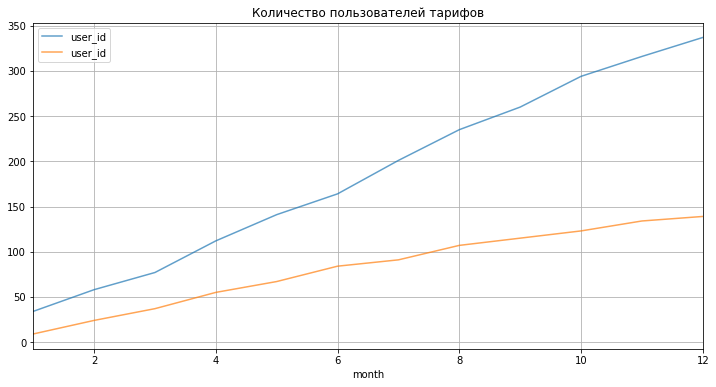

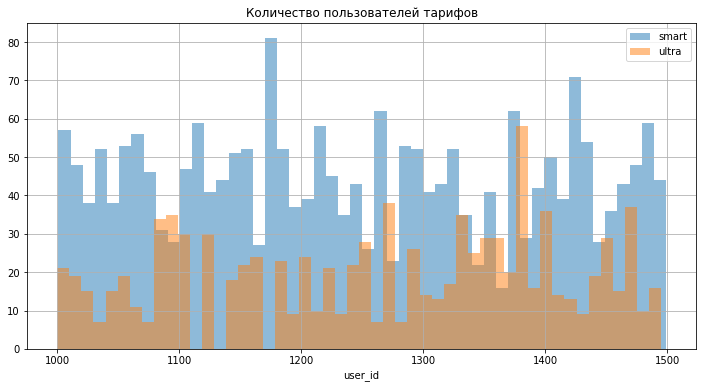

In [151]:
#Сравним количество пользователей тарифов
smart_ultra_comparison('Количество пользователей тарифов','user_id', 'count')


Визуальное подтверждение, что тариф Smart более привлекателен для клиентов.

Тариф Smart:
 поле "total_calls_in_month": среднее - 58.46, дисперсия - 672.88, стандартное отклонение - 25.94
Тариф Ultra:
 поле "total_calls_in_month": среднее - 73.39, дисперсия - 1928.69, стандартное отклонение - 43.92


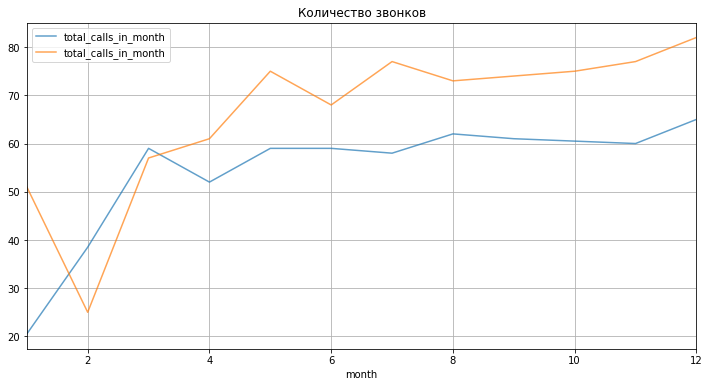

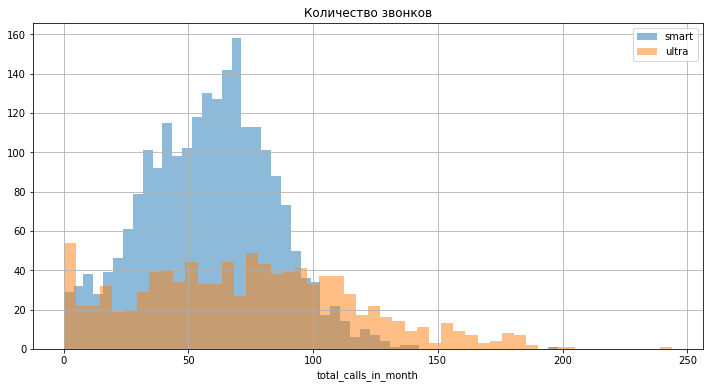

Тариф Smart:
 поле "total_calls_duration_in_month": среднее - 429.45, дисперсия - 37974.77, стандартное отклонение - 194.87
Тариф Ultra:
 поле "total_calls_duration_in_month": среднее - 540.78, дисперсия - 106105.73, стандартное отклонение - 325.74


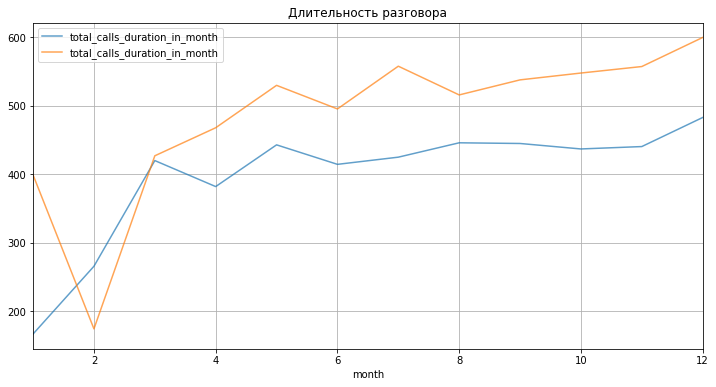

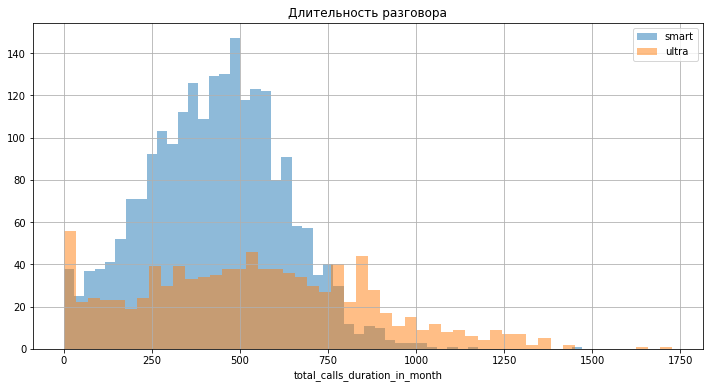

In [152]:
#Сравним количество звонков и длительность разговора
smart_ultra_comparison('Количество звонков','total_calls_in_month', 'median')
smart_ultra_comparison('Длительность разговора','total_calls_duration_in_month', 'median')

Начмная с марта показатели тарифа Ultra превосходят Smart. Длитедьность разговоров на тарифе Ultra шире, но в то же время есть и люди, еоторые говорят меньше 200мин.

Тариф Smart:
 поле "mb_used": среднее - 16208.39, дисперсия - 34462496.46, стандартное отклонение - 5870.48
Тариф Ultra:
 поле "mb_used": среднее - 19468.81, дисперсия - 101751013.78, стандартное отклонение - 10087.17


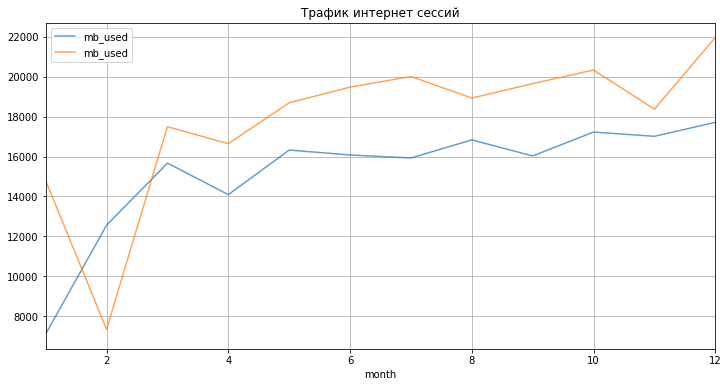

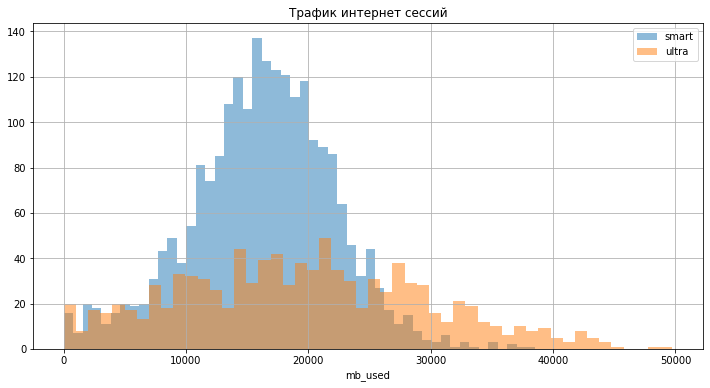

In [153]:
#Сравним трафик интернет сессий
smart_ultra_comparison('Трафик интернет сессий','mb_used', 'median')

Среднее значение трафика на тарифе Smart превышает лимит в 15Гб, в то время как на Ultra большая часть остается в пределах 30Гб.

Тариф Smart:
 поле "total_mes_in_month": среднее - 33.38, дисперсия - 796.81, стандартное отклонение - 28.23
Тариф Ultra:
 поле "total_mes_in_month": среднее - 49.36, дисперсия - 2285.27, стандартное отклонение - 47.80


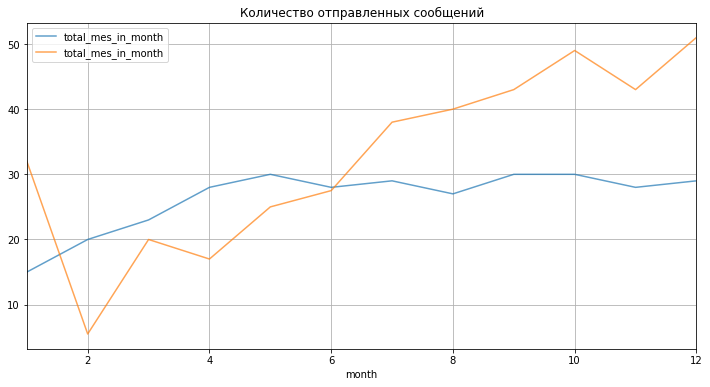

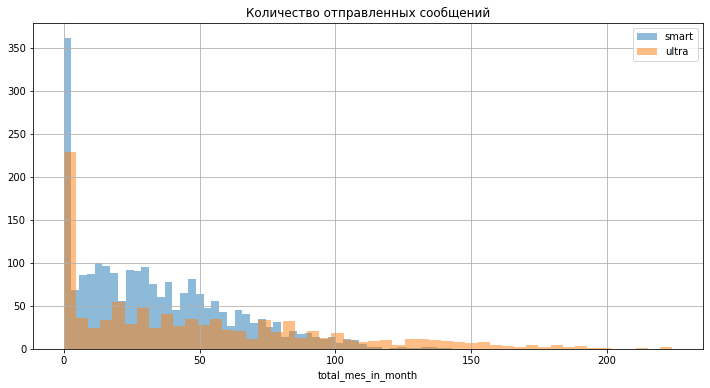

In [154]:
#Сравним количество отправленных сообщений
smart_ultra_comparison('Количество отправленных сообщений','total_mes_in_month', 'median')

Видно, что сообщения как sms-ки отпраляются редко как на Smart, так и на Ultra. С появлением мессенджеров, отправлять сообщения не выгодно. 

Тариф Smart:
 поле "total_paid": среднее - 1247.13, дисперсия - 631904.59, стандартное отклонение - 794.92
Тариф Ultra:
 поле "total_paid": среднее - 2059.80, дисперсия - 125843.21, стандартное отклонение - 354.74


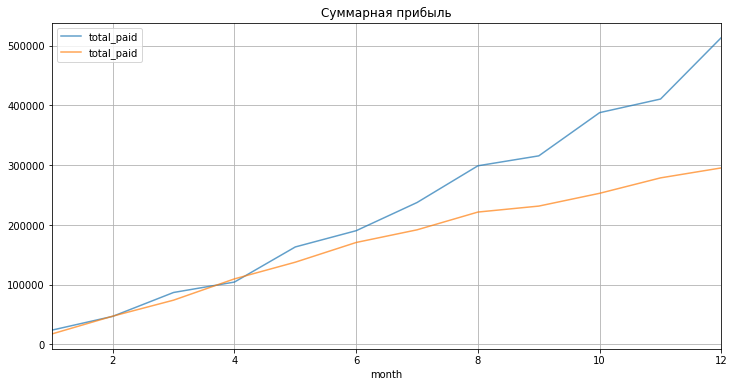

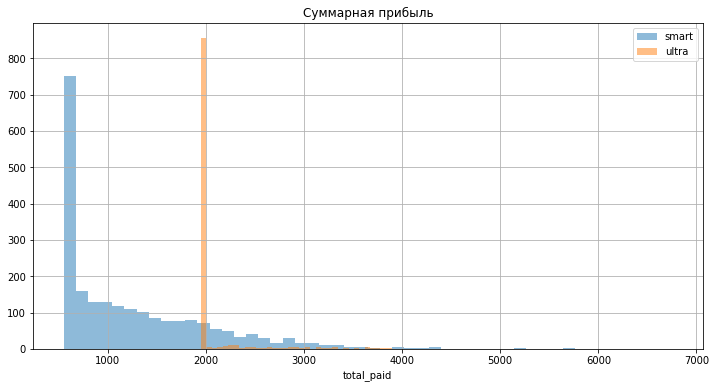

Тариф Smart:
 поле "total_paid": среднее - 1247.13, дисперсия - 631904.59, стандартное отклонение - 794.92
Тариф Ultra:
 поле "total_paid": среднее - 2059.80, дисперсия - 125843.21, стандартное отклонение - 354.74


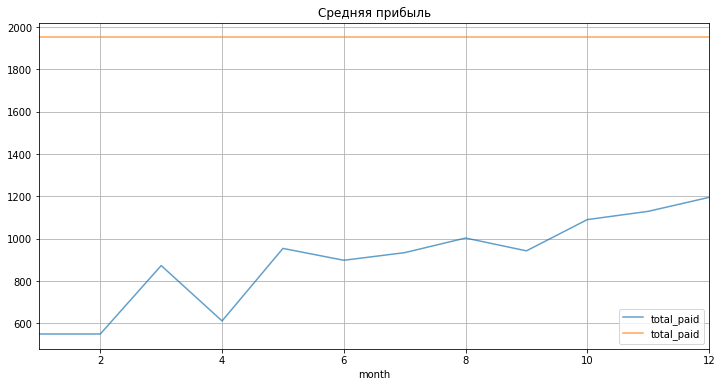

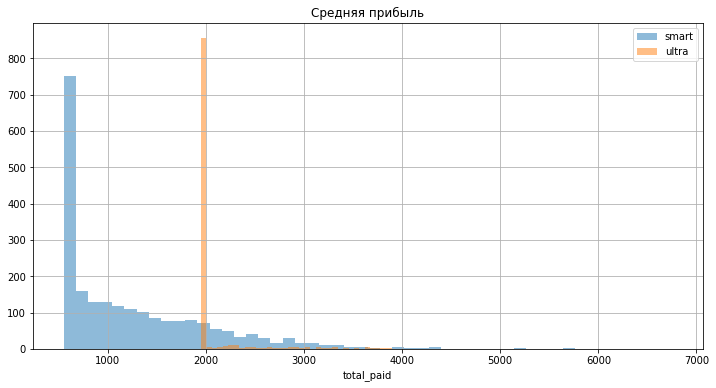

In [155]:
#Cравним среднюю и суммарную прибыль
smart_ultra_comparison('Суммарная прибыль','total_paid', 'sum')
smart_ultra_comparison('Средняя прибыль','total_paid', 'median')

До апреля суммарная прибыль была примерно одинаковая, потом Smart начинает увеличивать количество продаж. Скорее всего, из-за большого количества клиентов, а также в счет превышения абонентами лимита. 

Тариф Smart более привлекательное предложения для привлечения клиентов. Прибыль до апреля с обоих тарифов была применрно одинаковая, после Smart увеличивает свои продажи. Большая часть абонентов Smart превышают лимит, в то время как абоненты Ultra не выходят за пределы абонентской платы. Сообщения используются очень мало на обоих тарифах. Если 50 сообщений как-то соизмеримы, то 1000 сообщений на Ultra явно превышает потребности абонентов.

# ШАГ 4:

Гипотеза H_0: средние выручки тарифов Smart и Ultra одинаковы

Гипотеза H_1: средние выручки тарифов различны

In [156]:
alpha = .05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    user_smart['total_paid'], 
    user_ultra['total_paid'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")



p-значение: 2.5716849878978304e-182
Отвергаем нулевую гипотезу


Видим, что есть значимые различия, т.е отличия сумм выручек тарифов можно считать статистически значимыми.

In [157]:
#Отличается ли средняя выручка в Москве и других регионах
total_paid_msc = data.query('city == "Москва"')['total_paid'].mean()
total_paid_else = data.query('city !="Москва"')['total_paid'].mean()
print('Средняя выручка в Москве', total_paid_msc)
print('Средняя выручка в регионах', total_paid_else)

Средняя выручка в Москве 1514.8003273322422
Средняя выручка в регионах 1491.823665001921


Гипотеза H_0: средняя выручка в Москве равна средней выручке в других регионах. 

Гипотеза H_1: средние выручки в Москве и в других регионах различаются

In [158]:
alpha = .05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    data.query('city == "Москва"')['total_paid'], 
    data.query('city !="Москва"')['total_paid'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")



p-значение: 0.5153735337451972
Не получилось отвергнуть нулевую гипотезу


Выручка по Москве и в других регионах не отличается в статистически значимом смысле. Значение получено случайно с вероятностью 51%.

# ШАГ 5:

Вывод:
    На основе проделанного анализа можно сделать следующие выводы:
    1) Тариф Smart более популярен, чем Ultra. Но абоненты часто превышают лимит и им приходится переплачивать, что приносит прибыль для компании, но есть риск разочаровать абанентов, что может привести к оттоку
    2) С появлением мессенджеров смс потеряло свою актуальность. Если в тарифе Smart все соизмеримо, то в Ultra имеются нерасходуемые "запасы" - возможно, имеет смысл подумать, как использовать эту, по сути, упущенную выгоду.
    3) Выручки с тарифов существенно различаются.
    4) Выручка по Москве и в других регионах примерно одинаковая, значит связи с уровнем жизни нет.
    